# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importing  and Filtering the Data

## 1.1. Training Data

In [2]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00,2000,1,1,0,5
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00,2000,1,1,1,5
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00,2000,1,1,2,5
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00,2000,1,1,3,5
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00,2000,1,1,4,5


# 2. Data Exploration Analysis

## 2.1. Value over times

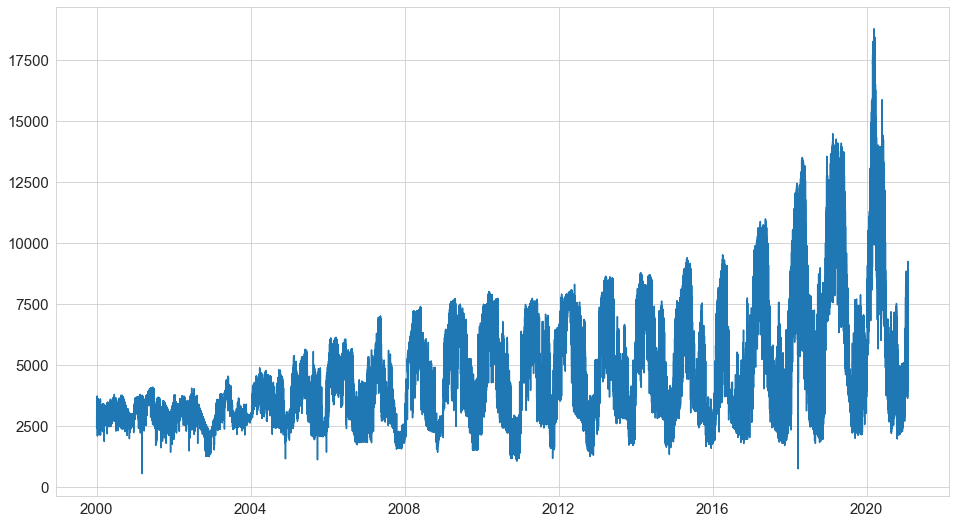

In [3]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(data['value'])

## 2.2. Test Data with one hundred first values

<AxesSubplot:ylabel='Density'>

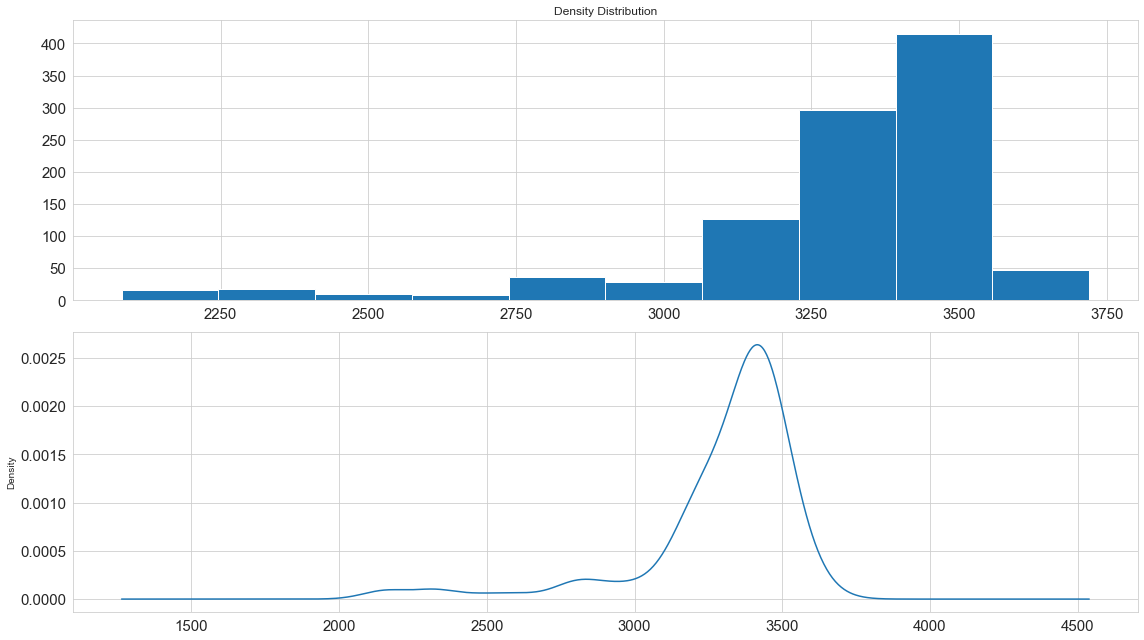

In [4]:
value = data['value'].head(1000)
plt.figure(tight_layout=True)
plt.subplot(211)
value.hist()
plt.title('Density Distribution')
plt.subplot(212)
value.plot(kind='kde')

## 2.3. Test Data with all values with another form

/Users/joaomacedo/opt/anaconda3/envs/AnalyticalModeling/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


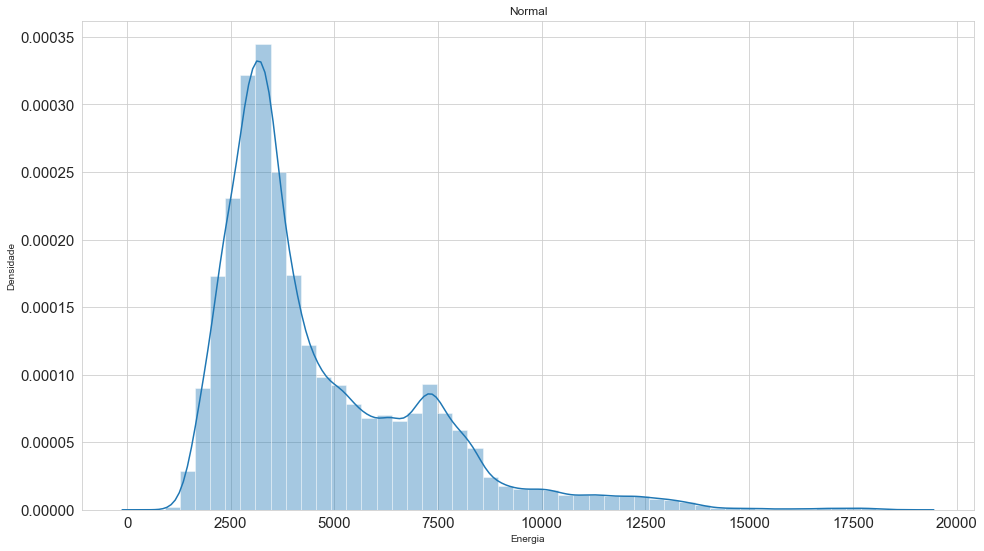

In [5]:
ax = sns.distplot(data['value'], kde=True)
ax.set(xlabel= 'Energia', ylabel='Densidade', title='Normal')
plt.show()

## 2.4. Histogram

Permite ver dados mes a mes.

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>]], dtype=object)

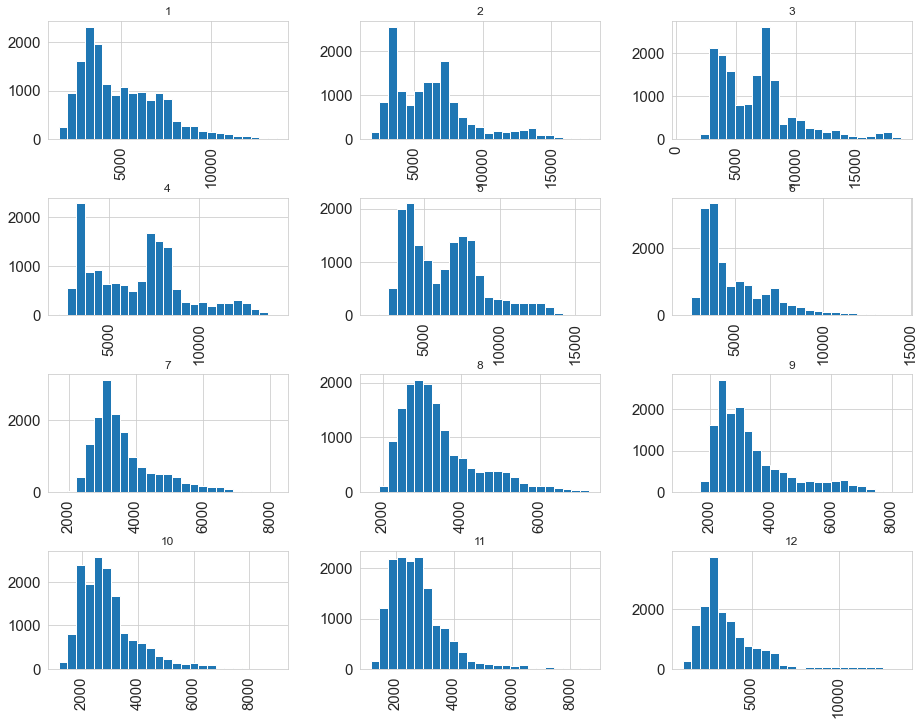

In [6]:
data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5. Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

<AxesSubplot:title={'center':'value'}, xlabel='year'>

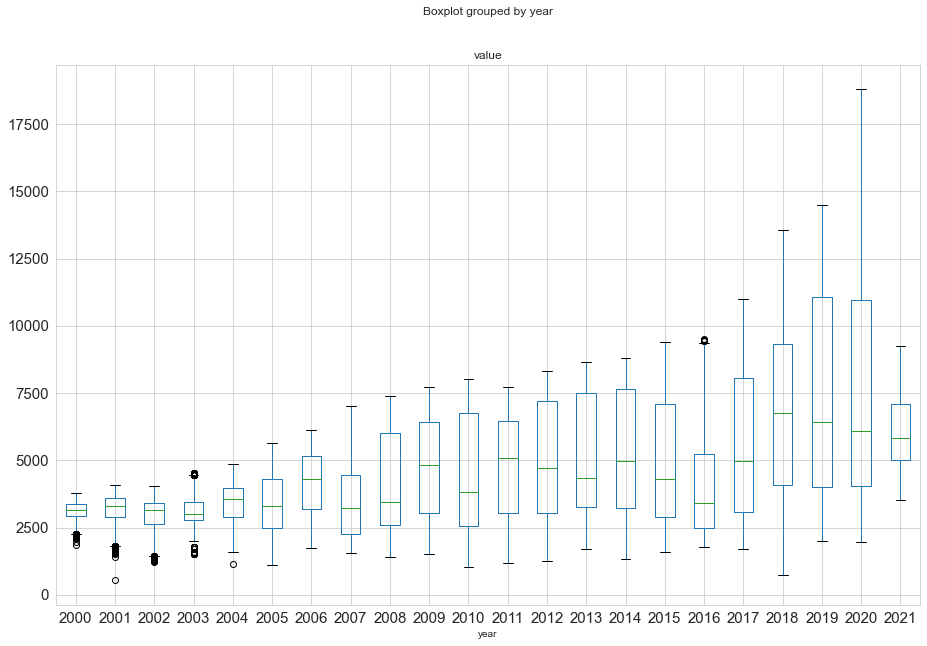

In [7]:
data.boxplot(figsize=(15,10), by='year', column=['value'])

# 3. Transformation

## 3.1. Box-Cox transformation

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

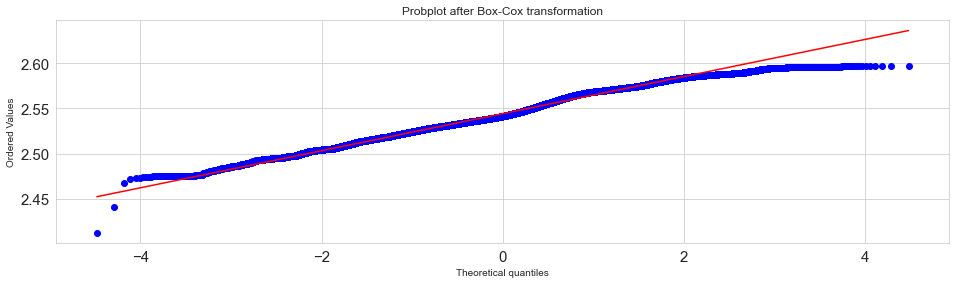

In [8]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2. Log transformation

A transformação Log diminui o vies dos dados.

None


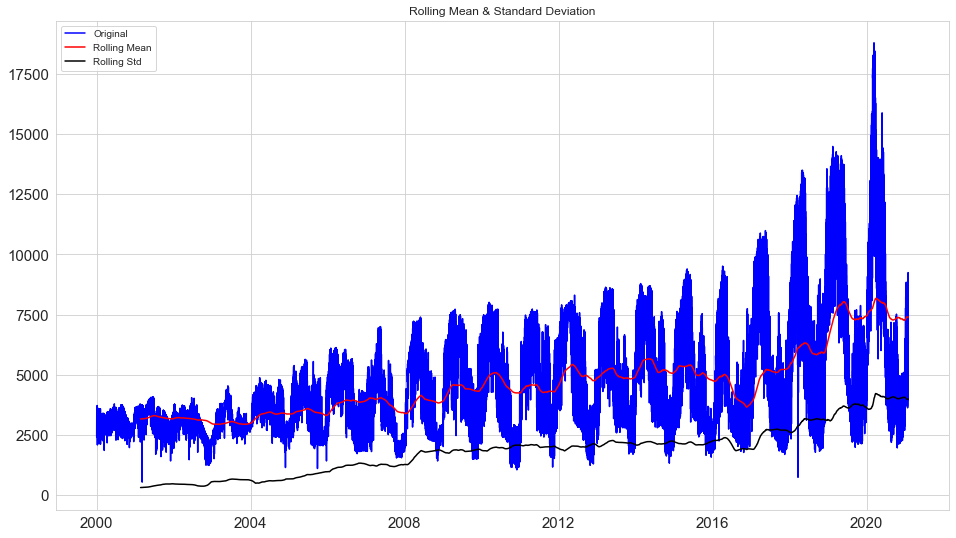

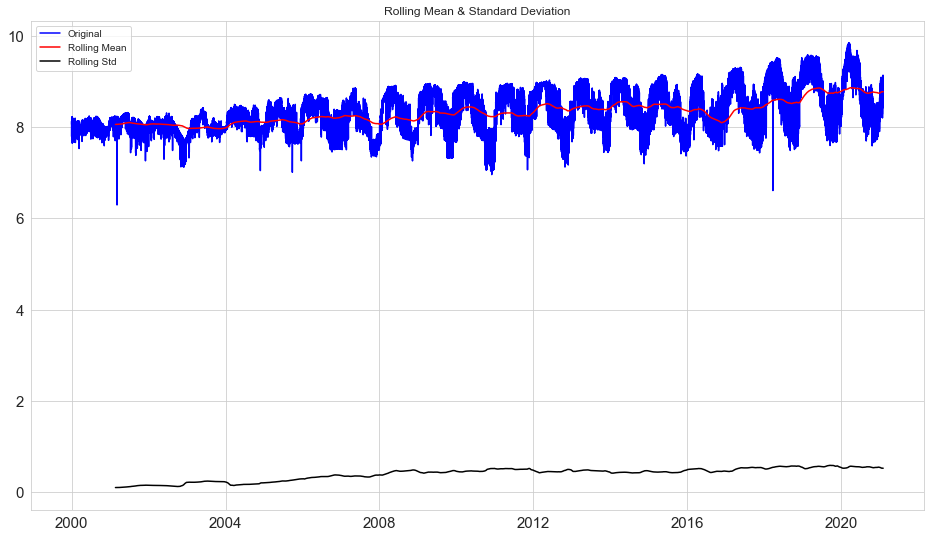

In [9]:
v_log = np.log(data['value'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=10000):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd  = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(data['value'])

test_stationarity(v_log)
v_log.to_csv('data/exported/transformed_log.csv')

## 4. Decomposition

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

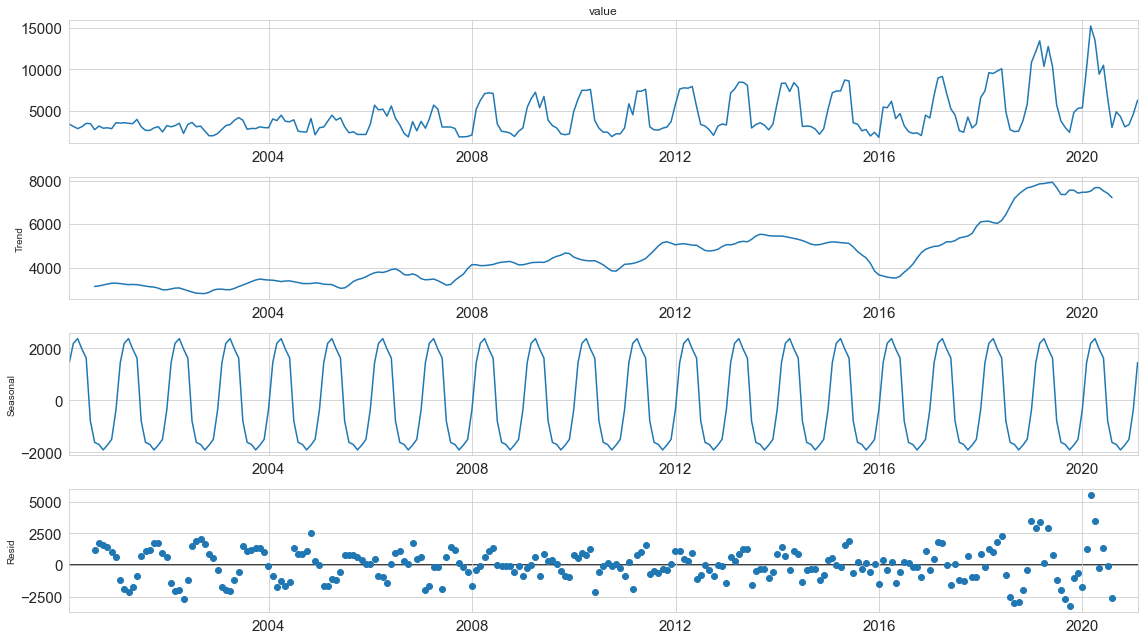

In [10]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Tests

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1. Test KPPS

In [11]:
statistic, p, lags, values = sm.tsa.kpss(v_log)
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

/Users/joaomacedo/opt/anaconda3/envs/AnalyticalModeling/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


Test statistic: 48.10423542021873
P Value: 0.01
Lags: 79
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/Users/joaomacedo/opt/anaconda3/envs/AnalyticalModeling/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


## 5.2. Test PP

In [12]:
pp(v_log)

Test Statistic,-23.966
P-value,0.000
Lags,79


## 5.3. Test Fuller

In [13]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(v_log.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")


Test statistic: -6.80431850339198
P Value: 2.196431999674153e-09 ???
Lags: 33
1%: -3.431006330034765
5%: -2.861830058724424
10%: -2.566924393122448
